Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 2 Classification

## Section 1: Data Preparation Part 1

### Load Libraries

In [119]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.evaluate import paired_ttest_5x2cv
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Sub-Section 1.1: Define and prepare your class variables.

#### Read in data

In [2]:
# read in the data
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


Our team's data set represents information collected from Hong Kong Horse Races. The data describes 29 race day attributes of 79,423 horses over 6,349 races (Note: Some horses are recorded in multiple races). Dates were obscured so timeframe of data is unknown. There are no missing values remaining in our imported data set. The raw data sets along with additional context can be located here: https://www.kaggle.com/gdaley/hkracing?select=runs.csv.

#### Create Show Variable

In [3]:
# Add a Show result feature
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


The two variables our team is focusing on for classification are Won and Show. The Won variable is a binary 0 or 1 response to descibe if the horse placed first in the race. If the horse placed first in the race, the Won variable records a 1. The Show variable (created above) is also a binary 0 or 1 response that represents whether a horse placed first, second, or third in a race. If the horse does place in the top 3, then the Show variable records a 1.

### Sub-Section 1.2: Remove variables that are not needed/useful for the analysis.

#### Drop Non-Important Attributes

In [4]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


Since our objective is to predict the result before the race starts, we must drop any predictors that are not known pre-race. Due to this, we dropped predictors such as: how many lengths the horse finished behind the winner, lap times, lap position, finish time, and finish position.

Also, we decided to drop any predictors that are not relevant to predicting the result of the race. These predictors include 'Unnamed: 0' (this was essentially an index value), the ID of the race, and the ID of the horse.

Next, we dropped Trainer ID, Jockey ID, and Horse Gear because they each have hundreds to thousands of small sample categorical levels that do not help predict the result of the race.

Finally, we separate out the response variables (Won and Show) into their own data sets. This leaves our predictor data set with a shape of 79423 instances and 8 attributes.

### Sub-Section 1.3: Use proper variable representations

#### One-Hot Encode Categorical Variables

In [5]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


After cleaning the data to the key predictors, we one-hot encode the remaining categorical variables horse country and horse type. This will change each categorical variable level into a binary 0 or 1 response. Then we drop the original attributes that were one-hot encoded. The number of attributes in the predictor data set increased from 10 to 33 after one-hot encoding.

### Sub-Section 1.4: Use pre-processing methods (as needed)

This completed the pre-processing our team performed in creating our predictor data set (runs_data), our 'Won' response data set (runs_target), and our 'Show' response data set (runs_target2). One additional pre-processing step not seen until the model creation in Section 5 is scaling. We built a scaling step into the pipeline that is used to scale, train, and fit the models. We used StandardScaler() and MinMaxScaler() in the models in Section 5 based on which was more appropriate. StandardScalar() scales each predictor based on using a standard normal distribution with a mean of 0 and standard deviation of 1. MinMaxScaler() scales each predictor so the values fall in the range [0,1]. When scaling the data set, we fit the scale to the training model and transform both the train and test sets based on the fit. We did this individually for each of the 10 cross validation splits. We will talk about the cross validation method chosen more in Section 4.

## Section 2: Data Preparation Part 2

### Sub-Section 2.1: Describe the final dataset that is used for classification

In [6]:
print('Won Response Set Shape: ',runs_target.shape)
print('Show Response Set Shape: ',runs_target2.shape)
runs_data.info()
runs_data.describe()

Won Response Set Shape:  (79423,)
Show Response Set Shape:  (79423,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   horse_no            79423 non-null  int64  
 1   horse_age           79423 non-null  int64  
 2   horse_rating        79423 non-null  int64  
 3   declared_weight     79423 non-null  float64
 4   actual_weight       79423 non-null  int64  
 5   draw                79423 non-null  int64  
 6   win_odds            79423 non-null  float64
 7   place_odds          79423 non-null  float64
 8   horse_country_ARG   79423 non-null  uint8  
 9   horse_country_AUS   79423 non-null  uint8  
 10  horse_country_BRZ   79423 non-null  uint8  
 11  horse_country_CAN   79423 non-null  uint8  
 12  horse_country_FR    79423 non-null  uint8  
 13  horse_country_GB    79423 non-null  uint8  
 14  horse_country_GER   79423 non-nul

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
count,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,...,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000
mean,6.905644,3.339461,61.035103,1104.952609,122.730091,6.875729,28.806138,7.421841,0.001599,0.376415,...,0.000151,0.025736,0.003840,0.000541,0.950367,0.000214,0.013762,0.002997,0.001939,0.000604
std,3.760600,0.876864,11.750531,62.350596,6.305551,3.747588,30.093854,8.613459,0.039956,0.484489,...,0.012291,0.158346,0.061851,0.023262,0.217187,0.014629,0.116501,0.054660,0.043991,0.024576
min,1.000000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,60.000000,1062.000000,118.000000,4.000000,7.700000,2.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.000000,60.000000,1102.000000,123.000000,7.000000,15.000000,4.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,3.000000,60.000000,1146.000000,128.000000,10.000000,38.000000,8.200000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.000000,10.000000,138.000000,1369.000000,133.000000,15.000000,99.000000,101.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The final predictor data set contains 33 attributes and 79,423 instances. The data set contains 8 coninuous attributes and 25 binary attributes created from one-hot encoding. The response sets for Won and Show each contain 79,423 instances as well. The descriptive statistics for each predictor are listed above. You can see that all one-hot encoded predictors have a min of 0 and max of 1 since these are binary variables. All other continuous variables do not appear to have any concerning outliers when looking at the min and max values.

Remaining original continuous features contained in the runs_data set:
- Horse_no - the number assigned to this horse, in the race
- Horse_age: all horses in the data set are 2, 3, 4, 5, 6, 7, 8, 9, or 10 years old at the time of race. The average age of horses in the dataset is 3.3 years
- Horse_rating - rating number assigned by HKJC to this horse at the time of the race
- Declared_weight: floating point value for the weight of the horse, the jockey, and the equipment in pounds.
- Actual_weight: integer value for the weight the horse carried; i.e. the weight of the Jockey and equipment
- Draw - post position number of the horse in this race
- Win_odds: floating point value for the odds of the horse to win the race
- Place_odds: floating point value for the odds of the horse to place in 1st, 2nd, or 3rd

Remaining original categorical features contained in the runs_data set that were one-hot encoded:
- Horse_country: a country code for the country of origin for the horse. Examples are NZ, AUS, USA
- Horse_type: examples are gelding, mare, rig

Response Variables:
- Won: a boolean value where 1 indicates the horse finished first in the race and 0 indicates the horse did not. A horse with a Result of 1 will have a Won response of 1. All others will have a Won response of 0.
- Show: a boolean value where 1 indicates the horse placed in the top 3 of the race and 0 indicates the horse did not. A horse with a Result of 1, 2, or 3 will have a Show response of 1. All others will have a Show response of 0.

*Show is the one new variable created from the original set*


## Section 3: Modeling and Evaluation 1

	• Modeling and Evaluation 1
		○ Choose and explain your evaluation metrics that you will use (i.e., accuracy,
		precision, recall, F-measure, or any metric we have discussed).
			- Why are the measure(s) appropriate for analyzing the results of your modeling?
			- Give a detailed explanation backing up any assertions.

### Sub-Section 3.1: Choose and explain your evaluation metrics that you will use. (Give a detailed explanation backing up any assertions.)

#### What evaluation metrics will our team use? Why are the measure(s) appropriate for analyzing the results of your modeling?

The real life application of predicting Won and Show would be from the perspective of someone placing a wager for that one of the events will occur. The models will tell a better to place a wager only when that event is predicted to occur. This means that the better will only lose money when a False Positive occurs and will not lose any money from a False Negative. For this reason, our team is focused on maximizing precision.

The one downfall of focusing on precision alone would be that a model could accurately predict a very small number of positive predictions and be optimal. Having too small of a number of positive predicitions would not give much opportunity to a better to make money. A secondary metric we are observing is Area Under the Curve (AUC). AUC score provides a good balance between sensitivity and specificity. A significantly higher AUC by two models with similar precision signals that there are a better balance of predictions.

Since 92% of the observations in the data set are losers, creating a model that predicts a loss for every observation would have an accuracy of 92% but offer no practical use. Therefore, we are not using accuracy to select a model. We will display it as a reference for each of the models.

## Section 4: Modeling and Evaluation 2

### Sub-Section 4.1: Choose the method you will use for dividing your data into training and testing splits. Explain why your chosen method is appropriate or use more than one method as appropriate.

For dividing our test and train data sets, we used Stratified K Fold Cross Validation (CV) with 10 splits. Stratified K Fold Cross Validation will randomly distribute each instance of a data set into a test or train set based on a inputted train/test percentage. After distributing every instance between the train and test sets, we have created a split. Our team decided to create 10 splits which results in 10 train and 10 test sets. The Stratified version ensures the responses in each split are as close to the same balance as possible (+/- 1 instance). This will ensure the model will have sufficient positive value to train on and we can see how well the model actually performs with sufficient postive values in the test set. 

Using this CV method will allow us to capture the mean Precision and AUC from 10 different models. These 10 models are trained and tested on 10 randomly generated train/test sets with nearly identical response class balance. This method will make it much more likely the most generalizable model will have the best scoring metrics compared to a single test/train split. Using a single test/train split will make it difficult to determine if your model is overfitting the data in that paticular random test/train split.

In [7]:
cv = StratifiedKFold(n_splits = 10, shuffle = True ,random_state = 0)

In [8]:
# training test split for showing confusion matrix
# Note all evaluation will actually use kFold CrossValidation

#train test split won
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

#train test split place
X_train_place,X_test_place,Y_train_place,Y_test_place = train_test_split(runs_data,runs_target2,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train_place = mmscl_obj.fit_transform(X_train_place,y = None)
X_test_place = mmscl_obj.transform(X_test_place)

## Section 5: Modeling and Evaluation 3

	• Modeling and Evaluation 3
		○ Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM
        for task one and the same or different algorithms for task two). 
		○ Two modeling techniques must be new (but the third could be SVM or logistic regression). 
		○ Adjust parameters as appropriate to increase generalization performance using your chosen metric. 
		○ You must investigate different parameters of the algorithms!

### Sub-Section 5.1: Create three different classification/regression models for each task

### Sub-Section 5.1.1: Model 1 KNN

K-Nearest Neighbors is an algorithm frequently used for classification. In order to classify an observation, the algorithm measures the distance from the given observation to it's K nearest neighbors, where K is a tunable parameter.

For each iteration of the model fitting, we try a different K value and print out the model precision and AUC score. Because the data set is not balanced, we use AUC as the primary metric for comparing model performance. If we used accuracy, we could achieve an accuracy of over 90% simply by classifying every observation as a "loss", but this has no practical use so we use Precision as a secondary metric instead.

First, we implemented two models. Both use Euclidean distance but one uses a uniform weight and the other uses distance. For uniform weight, all the nearest neighbors have the same impact in classification. In distance, closer neighbors have more impact.

The difference in model performance for uniform vs. distance was negligable, but the model with weights='distance' trained more quickly so we elected to use that parameter.

#### Euclidean Distance, Uniform Weights

In [9]:
# Use Euclidean distance and iterate over several K-values
## ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
Kvals = [3,5,7,9,11,13,15,17]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='uniform', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.175  AUC: 0.517
Precision of classifier with 5 neighbors is: 0.196  AUC: 0.508
Precision of classifier with 7 neighbors is: 0.241  AUC: 0.506
Precision of classifier with 9 neighbors is: 0.150  AUC: 0.501
Precision of classifier with 11 neighbors is: 0.200  AUC: 0.501
Precision of classifier with 13 neighbors is: 0.222  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.000  AUC: 0.500
Precision of classifier with 17 neighbors is: 0.000  AUC: 0.500


#### Euclidean Distance, Distance Weights

In [11]:
# Use Euclidean distance - sqrt(sum((x - y)^2))
## ‘distance’ : weight points by the inverse of their distance. 
##    in this case, closer neighbors of a query point will have a greater 
##    influence than neighbors which are further away.

for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)    

Precision of classifier with 3 neighbors is: 0.173  AUC: 0.520
Precision of classifier with 5 neighbors is: 0.189  AUC: 0.511
Precision of classifier with 7 neighbors is: 0.225  AUC: 0.508
Precision of classifier with 9 neighbors is: 0.216  AUC: 0.504
Precision of classifier with 11 neighbors is: 0.222  AUC: 0.503
Precision of classifier with 13 neighbors is: 0.194  AUC: 0.502
Precision of classifier with 15 neighbors is: 0.222  AUC: 0.502
Precision of classifier with 17 neighbors is: 0.238  AUC: 0.501


The next parameter we experimented with was the weight metric. We re-ran the model several times using different metrics from the sklearn DistanceMetric library, to include Manhatten and Chebyshev.

Again, the model performance for the different metrics was negligable so we elected to use weights = distance since it is well optimized for large data sets.

#### Euclidean Distance

In [12]:
# Use Euclidean Distance
Kvals = [5,7,9,11,13,15]
for x in Kvals:
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When K =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When K = 5
   Mean Precision:  0.17242893921665783
   Mean AUC:  0.6040195932809418
   Mean Accuracy:  0.9108570467121682
   Mean Time per Split:  19.08608787059784
 
When K = 7
   Mean Precision:  0.19674188127726275
   Mean AUC:  0.6257389755284041
   Mean Accuracy:  0.9153771712598575
   Mean Time per Split:  19.473681282997134
 
When K = 9
   Mean Precision:  0.23136980840990629
   Mean AUC:  0.6404224291268119
   Mean Accuracy:  0.9176812895633593
   Mean Time per Split:  20.067448234558103
 
When K = 11
   Mean Precision:  0.2159179819186213
   Mean AUC:  0.6528758023162878
   Mean Accuracy:  0.9184367192169669
   Mean Time per Split:  19.565009713172913
 
When K = 13
   Mean Precision:  0.2171270104164841
   Mean AUC:  0.660832851188448
   Mean Accuracy:  0.9190033049314188
   Mean Time per Split:  19.730614042282102
 
When K = 15
   Mean Precision:  0.23503663003663006
   Mean AUC:  0.6665851009072934
   Mean Accuracy:  0.9192677092731951
   Mean Time per Split:  19.49809453487

#### Manhatten Distance

In [13]:
# Use Manhatten distance - sum(|x - y|)

for x in Kvals:
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', KNeighborsClassifier(n_neighbors=x, weights='distance', metric='manhattan')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When K =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')
    

When K = 5
   Mean Precision:  0.19263556683238853
   Mean AUC:  0.6151369526137682
   Mean Accuracy:  0.909786803183714
   Mean Time per Split:  40.32731068134308
 
When K = 7
   Mean Precision:  0.21996485390991438
   Mean AUC:  0.6387919719062919
   Mean Accuracy:  0.9149490754336813
   Mean Time per Split:  40.205027556419374
 
When K = 9
   Mean Precision:  0.20632622141773066
   Mean AUC:  0.6531549772296296
   Mean Accuracy:  0.9168125288170534
   Mean Time per Split:  41.48882887363434
 
When K = 11
   Mean Precision:  0.20776800155721178
   Mean AUC:  0.6657328359865076
   Mean Accuracy:  0.9179205129166821
   Mean Time per Split:  41.21237430572509
 
When K = 13
   Mean Precision:  0.24994818262233123
   Mean AUC:  0.6748271656400812
   Mean Accuracy:  0.9187389053452588
   Mean Time per Split:  43.45358581542969
 
When K = 15
   Mean Precision:  0.28327311577311576
   Mean AUC:  0.6827735083539113
   Mean Accuracy:  0.9192551164011601
   Mean Time per Split:  41.324105453491

#### Chebyshev Distance

In [14]:
# Use ChebyshevDistance distance - max(|x - y|)

for x in Kvals:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', KNeighborsClassifier(n_neighbors=x, weights='distance', metric='chebyshev')))
    pipeline = Pipeline(steps=steps)
    

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When K =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When K = 5
   Mean Precision:  0.15033387893038463
   Mean AUC:  0.5881386683922709
   Mean Accuracy:  0.9110459524743361
   Mean Time per Split:  62.624655437469485
 
When K = 7
   Mean Precision:  0.18082913945412105
   Mean AUC:  0.608264867524398
   Mean Accuracy:  0.9158178520320416
   Mean Time per Split:  39.64154880046844
 
When K = 9
   Mean Precision:  0.20722443917570144
   Mean AUC:  0.6218686320398369
   Mean Accuracy:  0.9179834614248022
   Mean Time per Split:  122.86892931461334
 
When K = 11
   Mean Precision:  0.2212712038563432
   Mean AUC:  0.6300848880306799
   Mean Accuracy:  0.9188144483106196
   Mean Time per Split:  39.7421959400177
 
When K = 13
   Mean Precision:  0.21245532245532245
   Mean AUC:  0.6398721903797017
   Mean Accuracy:  0.9191669869045862
   Mean Time per Split:  39.31500167846679
 
When K = 15
   Mean Precision:  0.24845238095238092
   Mean AUC:  0.6461848187093986
   Mean Accuracy:  0.9194943429248937
   Mean Time per Split:  249.904947209358

With each of the KNN models above, the precision and AUC tend to stabilize at around k=9 or 11. Note as the K value increases so too does the precision but the AUC decreases. Choosing a smaller K-value such as 7 produces a good balace between the different metrics.

We fit a final KNN using the parameters selected: Euclidean, Distance weights for neighbors, and 7 neighbors.

#### Predict Show Horses

Next we generated several more KNN models where we predicted Show (top 3 finish) instead of Win. We tried several different metrics of measure and K values.

#### Euclidean distance for Show

In [15]:
# Use Euclidean Distance

for x in Kvals:
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When K =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When K = 5
   Mean Precision:  0.4094219606097698
   Mean AUC:  0.661060514693541
   Mean Accuracy:  0.7319543810845931
   Mean Time per Split:  18.219727063179015
 
When K = 7
   Mean Precision:  0.4269769679831178
   Mean AUC:  0.6780504180383631
   Mean Accuracy:  0.7402391260217085
   Mean Time per Split:  18.482177114486692
 
When K = 9
   Mean Precision:  0.4430235499340947
   Mean AUC:  0.689732690526102
   Mean Accuracy:  0.7462574963969073
   Mean Time per Split:  18.360480237007142
 
When K = 11
   Mean Precision:  0.4518151942224621
   Mean AUC:  0.6972588569809803
   Mean Accuracy:  0.7495310724520368
   Mean Time per Split:  18.639691734313963
 
When K = 13
   Mean Precision:  0.46257203098108535
   Mean AUC:  0.7020588253860991
   Mean Accuracy:  0.7525654901472665
   Mean Time per Split:  18.884888172149658
 
When K = 15
   Mean Precision:  0.46594314205038206
   Mean AUC:  0.7059347899543055
   Mean Accuracy:  0.7539000952169501
   Mean Time per Split:  20.0192576169967

#### Manhattan distance for Show

In [16]:
# Use Manhatten distance - sum(|x - y|)

for x in Kvals:
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', KNeighborsClassifier(n_neighbors=x, weights='distance', metric='manhattan')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When K =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')
    

When K = 5
   Mean Precision:  0.424374626251461
   Mean AUC:  0.6688167367295115
   Mean Accuracy:  0.7358826612543103
   Mean Time per Split:  41.78424046039581
 
When K = 7
   Mean Precision:  0.4400054944502988
   Mean AUC:  0.684682778779574
   Mean Accuracy:  0.7430972403380381
   Mean Time per Split:  41.52912027835846
 
When K = 9
   Mean Precision:  0.4547013904143743
   Mean AUC:  0.6969922949861043
   Mean Accuracy:  0.7483476341585522
   Mean Time per Split:  41.085483479499814
 
When K = 11
   Mean Precision:  0.47194596888629403
   Mean AUC:  0.7053981261474536
   Mean Accuracy:  0.7533587285358824
   Mean Time per Split:  41.232865595817564
 
When K = 13
   Mean Precision:  0.48109998567044243
   Mean AUC:  0.7106858929423717
   Mean Accuracy:  0.7558139248440785
   Mean Time per Split:  41.142901468276975
 
When K = 15
   Mean Precision:  0.4880986848694849
   Mean AUC:  0.7155242658119074
   Mean Accuracy:  0.7575010748485502
   Mean Time per Split:  41.507507944107054

#### Chebyshev distance for Show

In [17]:
# Use ChebyshevDistance distance - max(|x - y|)

for x in Kvals:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', KNeighborsClassifier(n_neighbors=x, weights='distance', metric='chebyshev')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When K =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When K = 5
   Mean Precision:  0.3907025670550385
   Mean AUC:  0.6513566862858077
   Mean Accuracy:  0.7277994054401651
   Mean Time per Split:  40.719473314285274
 
When K = 7
   Mean Precision:  0.4024627010620536
   Mean AUC:  0.6650255934735971
   Mean Accuracy:  0.7353538113554163
   Mean Time per Split:  40.7617104768753
 
When K = 9
   Mean Precision:  0.4088738016541617
   Mean AUC:  0.6758191030224958
   Mean Accuracy:  0.7402391228512977
   Mean Time per Split:  40.34527790546417
 
When K = 11
   Mean Precision:  0.42137830938724125
   Mean AUC:  0.681581131919888
   Mean Accuracy:  0.7448599364782816
   Mean Time per Split:  40.467613911628725
 
When K = 13
   Mean Precision:  0.4266737507774979
   Mean AUC:  0.6871702386801746
   Mean Accuracy:  0.7474032575274352
   Mean Time per Split:  40.49310472011566
 
When K = 15
   Mean Precision:  0.43572210992890764
   Mean AUC:  0.6903375958744932
   Mean Accuracy:  0.7500472676558834
   Mean Time per Split:  40.69495067596436
 

Across the different KNN models created to classify Show horses, the AUCs were all comparable to that of the KNN models for Win horses: slightly more than 0.5

However, the precision was lower almost across the board. If I had to select one model, it would be the Euclidean distance metric with a K value of 13, although there a better model choices than KNN as we will see in the following sections of this Lab. In fact, in the Mini Lab we generated several Logistic Regression and SVM with significantly higher AUCs and precisions.

#### Model to predict Won

Precision of classifier with 7 neighbors is: 0.147  AUC: 0.504


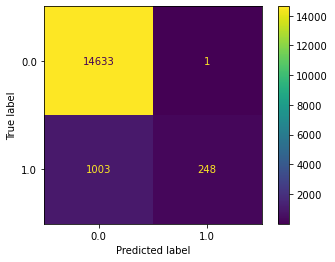

In [127]:
x=7
clf_knnw = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
clf_knnw.fit(X_train,Y_train)
yhatknnw = clf_knnw.predict(X_test)
acc = mt.accuracy_score(Y_test,yhatknnw)
prec = mt.precision_score(Y_test,yhatknnw)
auc = roc_auc_score(Y_test,yhatknnw)
conf = mt.confusion_matrix(Y_test,yhatknnw)
print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)
plot_confusion_matrix(clf_knn, X_test, Y_test)

From the Confusion Matrix above, notice the large number of false positives. The model incorrectly classified over 1000 observations as wins when they should have been loses. It only correctly classified about 50 wins. Since this data set is results of horse races, you can assume an interested party would be a gambler. The KNN model would not be of much benefit to a gambler due to the large number of Type I error in proportion to true positive results.

#### Model to predict Show

Precision of classifier with 13 neighbors is: 0.431  AUC: 0.576


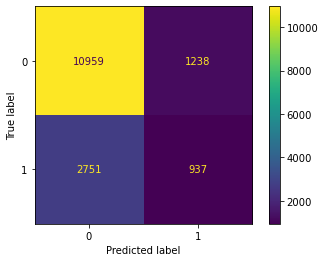

In [131]:
x=13
clf_knnp = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
clf_knnp.fit(X_train_place,Y_train_place)
yhatknnp = clf_knnp.predict(X_test_place)
acc = mt.accuracy_score(Y_test_place,yhatknnp)
prec = mt.precision_score(Y_test_place,yhatknnp)
auc = roc_auc_score(Y_test_place,yhatknnp)
conf = mt.confusion_matrix(Y_test_place,yhatknnp)
print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)
plot_confusion_matrix(clf_knnp, X_test_place, Y_test_place)

### Sub-Section 5.1.2: Model 2 Naive Bayes

#### Gaussian Naive Bayes on the 'won' target response variable:

In [35]:
var = [.25,.5,1,2,3,4,5,6,7,8,9,10,15,20]
for x in var:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', GaussianNB(var_smoothing=x)))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When VAR =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When VAR = 0.25
   Mean Precision:  0.10124209461011588
   Mean AUC:  0.7060093520803179
   Mean Accuracy:  0.32394082467736857
   Mean Time per Split:  0.12262535095214844
 
When VAR = 0.5
   Mean Precision:  0.10456674092985299
   Mean AUC:  0.7064824462753292
   Mean Accuracy:  0.35537928863707896
   Mean Time per Split:  0.1320017337799072
 
When VAR = 1
   Mean Precision:  0.13464804507961875
   Mean AUC:  0.7078198496040616
   Mean Accuracy:  0.584734025810513
   Mean Time per Split:  0.1339499235153198
 
When VAR = 2
   Mean Precision:  0.12364661142378834
   Mean AUC:  0.7102983251967856
   Mean Accuracy:  0.9149512118350647
   Mean Time per Split:  0.13050925731658936
 
When VAR = 3
   Mean Precision:  0.0918701729089594
   Mean AUC:  0.7120540608065447
   Mean Accuracy:  0.9166698142902108
   Mean Time per Split:  0.12529098987579346
 
When VAR = 4
   Mean Precision:  0.07395334712060467
   Mean AUC:  0.7133145585885231
   Mean Accuracy:  0.9178344350015738
   Mean Time per S

var at 1 for model

#### Complement Naive Bayes on the 'Won' target response variable:

In [36]:
alpha = [.25,.5,1,2,3,4,5,6,7,8,9,10,15,20]
for x in alpha:
    # define the pipeline
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', ComplementNB(alpha = x)))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Alpha =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Alpha = 0.25
   Mean Precision:  0.13109039000011966
   Mean AUC:  0.746798216845774
   Mean Accuracy:  0.5424425558703179
   Mean Time per Split:  0.07953248023986817
 
When Alpha = 0.5
   Mean Precision:  0.13125854602102036
   Mean AUC:  0.7469984833010325
   Mean Accuracy:  0.5429272898961285
   Mean Time per Split:  0.07764382362365722
 
When Alpha = 1
   Mean Precision:  0.13144789182233368
   Mean AUC:  0.7473594417308272
   Mean Accuracy:  0.5436701290525653
   Mean Time per Split:  0.08049778938293456
 
When Alpha = 2
   Mean Precision:  0.13188762202042997
   Mean AUC:  0.7478598415643519
   Mean Accuracy:  0.545407617248977
   Mean Time per Split:  0.08024260997772217
 
When Alpha = 3
   Mean Precision:  0.1322228259228747
   Mean AUC:  0.7480043669654013
   Mean Accuracy:  0.5469499527856468
   Mean Time per Split:  0.08230087757110596
 
When Alpha = 4
   Mean Precision:  0.132603557827293
   Mean AUC:  0.7480569177440437
   Mean Accuracy:  0.5487566887000315
   Mean T

### best model is  Complement alpha 10 

Alpha:20 AUC: 0.6783355383424494 ACC: 0.560717658168083


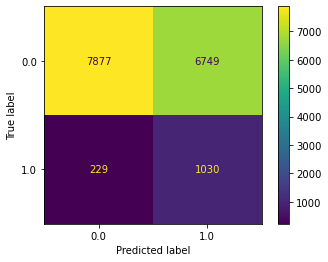

In [40]:
clf_cnbw = ComplementNB(alpha = 10)
clf_cnbw.fit(X_train,Y_train.values.ravel())
yhat = clf_cnbw.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('Alpha:20 AUC:',auc,'ACC:',acc)
plot_confusion_matrix(clf_cnbw,X_test,Y_test)

#### Gaussian Naive Bayes on the 'show' target response variable:

In [38]:
var = [.25,.5,1,2,3,4,5,6,7,8,9,10,15,20]
for x in var:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', GaussianNB(var_smoothing=x)))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When VAR =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When VAR = 0.25
   Mean Precision:  0.28051887901406747
   Mean AUC:  0.7047869038500877
   Mean Accuracy:  0.40098205854579794
   Mean Time per Split:  0.13249361515045166
 
When VAR = 0.5
   Mean Precision:  0.27802573761487837
   Mean AUC:  0.7065664399389135
   Mean Accuracy:  0.3925023607176582
   Mean Time per Split:  0.13243541717529297
 
When VAR = 1
   Mean Precision:  0.27729988516412574
   Mean AUC:  0.7088968244905948
   Mean Accuracy:  0.3893862134088763
   Mean Time per Split:  0.1283179998397827
 
When VAR = 2
   Mean Precision:  0.28406651374905645
   Mean AUC:  0.7120315750831143
   Mean Accuracy:  0.41226943657538556
   Mean Time per Split:  0.1347280502319336
 
When VAR = 3
   Mean Precision:  0.30923632380559907
   Mean AUC:  0.7141453838382417
   Mean Accuracy:  0.49067044381491975
   Mean Time per Split:  0.12682199478149414
 
When VAR = 4
   Mean Precision:  0.3878196453783128
   Mean AUC:  0.7156619205998382
   Mean Accuracy:  0.6685300598048473
   Mean Time per

var at 5

#### Complement Naive Bayes on the 'show' target response variable:

In [39]:
alpha = [.25,.5,1,2,3,4,5,6,7,8,9,10,15,20]
for x in alpha:
    # define the pipeline
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', ComplementNB(alpha = x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Alpha =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Alpha = 0.25
   Mean Precision:  0.348779042978297
   Mean AUC:  0.7420522889414106
   Mean Accuracy:  0.5865533522190746
   Mean Time per Split:  0.0731703519821167
 
When Alpha = 0.5
   Mean Precision:  0.3487835593297668
   Mean AUC:  0.7421102591549226
   Mean Accuracy:  0.5865659427132515
   Mean Time per Split:  0.07782747745513915
 
When Alpha = 1
   Mean Precision:  0.34888837823463803
   Mean AUC:  0.742215117807883
   Mean Accuracy:  0.5867170286433742
   Mean Time per Split:  0.07644126415252686
 
When Alpha = 2
   Mean Precision:  0.3491076074415228
   Mean AUC:  0.7423835494768083
   Mean Accuracy:  0.5870254957507083
   Mean Time per Split:  0.07784798145294189
 
When Alpha = 3
   Mean Precision:  0.34924588530136524
   Mean AUC:  0.7425179472166044
   Mean Accuracy:  0.5872458293988039
   Mean Time per Split:  0.08189048767089843
 
When Alpha = 4
   Mean Precision:  0.34945029839709896
   Mean AUC:  0.7426437245918666
   Mean Accuracy:  0.5875165250236072
   Mean Ti

Place model

Alpha:20 AUC: 0.6804427167023219 ACC: 0.5874095058231036


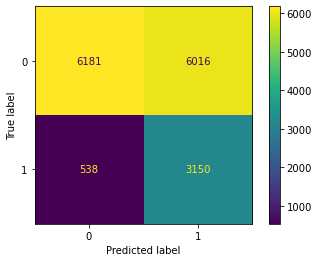

In [52]:
clf_cnbp = ComplementNB(alpha = 10)
clf_cnbp.fit(X_train_place,Y_train_place.values.ravel())
yhat = clf_cnbp.predict(X_test_place)
acc = mt.accuracy_score(Y_test_place,yhat)
auc = roc_auc_score(Y_test_place,yhat)
print('Alpha:20 AUC:',auc,'ACC:',acc)
plot_confusion_matrix(clf_cnbp,X_test_place,Y_test_place)

Next we will want to look at the feature importance for both winning models

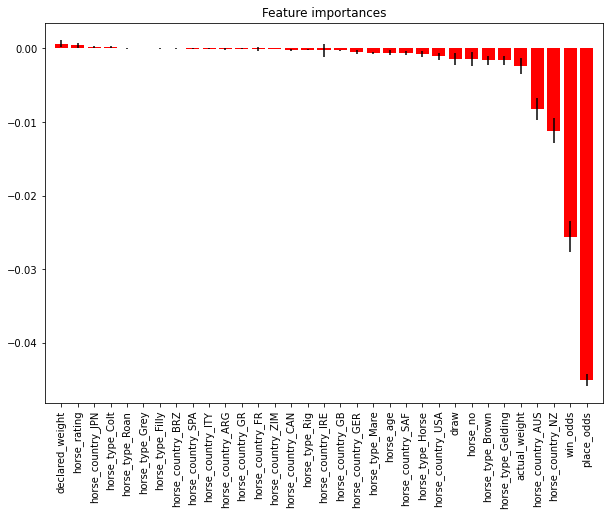

In [48]:
features = list(runs_data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(clf_cnbw, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

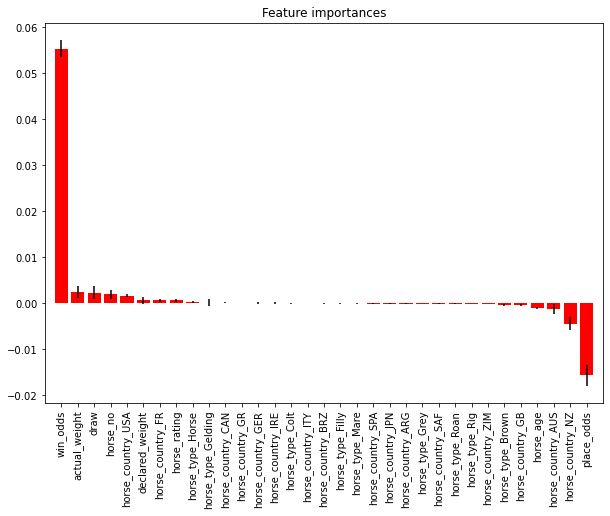

In [53]:
features = list(runs_data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(clf_cnbp, X_test_place, Y_test_place)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

#### Model to predict Won

Alpha:20 AUC: 0.6865902112258534 ACC: 0.7488825936418004 Prec: 0.13726023670248946


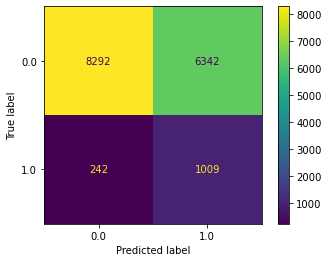

In [136]:
clf_cnbw = ComplementNB(alpha = 20)
clf_cnbw.fit(X_train,Y_train.values.ravel())
yhatcnbw = clf_cnbw.predict(X_test)
prec = mt.precision_score(Y_test,yhatcnbw)
auc = roc_auc_score(Y_test,yhatcnbw)
print('Alpha:20 AUC:',auc,'ACC:',acc,'Prec:',prec)
plot_confusion_matrix(clf_cnbw,X_test,Y_test)

#### Model to predict Show

Alpha:20 AUC: 0.680016973698415 ACC: 0.7488825936418004 Prec: 0.3431682090364725


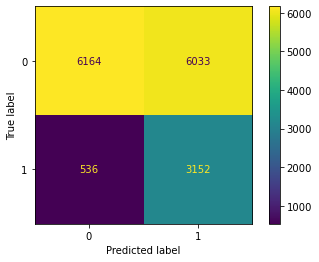

In [137]:
clf_cnbp = ComplementNB(alpha = 10)
clf_cnbp.fit(X_train_place,Y_train_place.values.ravel())
yhatcnbp = clf_cnbp.predict(X_test_place)
prec = mt.precision_score(Y_test_place,yhatcnbp)
auc = roc_auc_score(Y_test_place,yhatcnbp)
print('Alpha:20 AUC:',auc,'ACC:',acc,'Prec:',prec)
plot_confusion_matrix(clf_cnbp,X_test_place,Y_test_place)

### Sub-Section 5.1.3: Model 3 Random Forest

#### Task 1
The first parameter we want to look at is the performance of forest size to find an optimal number of trees based on the initial data. Determining the correct size of the forest can help keep us from overfitting the model or by wasting resources with building an unneccessarily large forest.

In [70]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)


    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.17467725859958705
   Mean AUC:  0.780821922374406
   Mean Accuracy:  0.7065585005960213
   Mean Time per Split:  1.383591651916504
 
When Trees = 75
   Mean Precision:  0.17462083131027992
   Mean AUC:  0.7807780566229459
   Mean Accuracy:  0.7060800126740345
   Mean Time per Split:  1.5990831136703492
 
When Trees = 100
   Mean Precision:  0.17457515070588273
   Mean AUC:  0.7803471813433926
   Mean Accuracy:  0.7058408178544099
   Mean Time per Split:  2.1231966972351075
 
When Trees = 128
   Mean Precision:  0.1745093070238754
   Mean AUC:  0.7805832098460467
   Mean Accuracy:  0.7058659750647819
   Mean Time per Split:  2.6664492368698123
 


Looking at this information we are aiming for the best precision in our models as we want the best possible number of positive results while limiting false positives. So from this we would look at building a forest with 64 trees. This is also nice because it is the least time consuming. Next we will use this to run a loop to fine the optimal max_depth. This is the metric that determines the overall size of each individual tree by limiting the number of levels it can break down the data into. We will be looking at four levels in this loop, 5,20,100, and no limit(none)

In [71]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)


    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.17467725859958705
   Mean AUC:  0.780821922374406
   Mean Accuracy:  0.7065585005960213
   Mean Time per Split:  1.4545721054077148
 
When Depth = 20
   Mean Precision:  0.23955061476791545
   Mean AUC:  0.7584604312431527
   Mean Accuracy:  0.8651397376034794
   Mean Time per Split:  3.808790111541748
 
When Depth = 100
   Mean Precision:  0.42608117018594954
   Mean AUC:  0.7465687263422632
   Mean Accuracy:  0.9192173742447803
   Mean Time per Split:  4.355546355247498
 
When Depth = None
   Mean Precision:  0.42608117018594954
   Mean AUC:  0.7465687263422632
   Mean Accuracy:  0.9192173742447803
   Mean Time per Split:  4.9744320631027215
 


After assessing these results we wanted to take a look at feature importance on the selected model above. The reason for this is we want to try to eliminate noise variables. This has a secondary side effect with random forests of letting them run faster since the number of features is reduces. There were two ways we went about doing this for random forest. The first was a manual look at the feature importance, and selecting what we deemed to be the most important. The second way was to use recursive feature elimination with cross-validation to look at removing variables. 

In [72]:
#model for feature elimination
clf_rf = RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
clf_rf.fit(X_train,Y_train.values.ravel())
yhat = clf_rf.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)

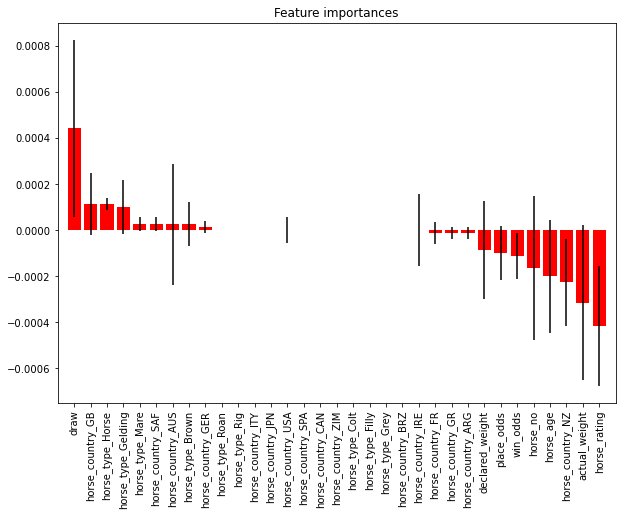

In [73]:
features = list(runs_data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(clf_rf, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

Just by looking at this graph we can make some simple eliminations of features that did not help in this model. Likely we would want to keep the first three factors and the last 15 factors in the model and eliminate the rest. This has been done in the data below.

In [77]:
optfeatures = featureorder[:4]
optfeatures2 = featureorder[-8:]
optfeatures = optfeatures + optfeatures2
dataopt = runs_data[optfeatures]

Optimal number of features : 16


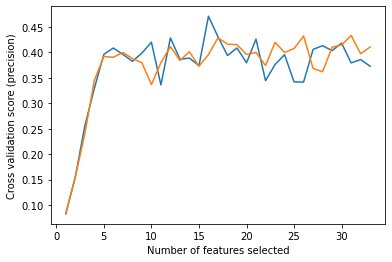

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 8.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 15.000
Column: 11, Selected False, Rank: 10.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected False, Rank: 5.000
Column: 15, Selected False, Rank: 16.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 12.000
Column: 18, Selected False, Rank: 9.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected False, Rank: 3.000
Column: 21, Selected False, Rank: 18.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected False, Rank: 11.000
Column: 24, Selected True, Rank: 1.000
Column: 25, Selecte

In [75]:
#Recursive Feature Elimination
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=clf_rf, step=1, cv=StratifiedKFold(2),
              scoring='precision',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, Y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (precision)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

In [78]:
#dropping features from dataset not selected by recursive feature elimination
dataopt2 = runs_data.drop(runs_data.columns[[8,10,11,14,15,17,18,20,21,23,25,26,28,29,30,31,32]],axis = 1)

After building out these new datasets we decided to run the same crossvalidated pieces against them. You can see the results of these below. The first two loops are run on the manually optimized data.

In [79]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)


    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.1758097910737143
   Mean AUC:  0.783398476001815
   Mean Accuracy:  0.7077924498757245
   Mean Time per Split:  1.5800112724304198
 
When Trees = 75
   Mean Precision:  0.17611779170585584
   Mean AUC:  0.783448719953382
   Mean Accuracy:  0.7090263753773464
   Mean Time per Split:  1.8281825304031374
 
When Trees = 100
   Mean Precision:  0.17567116222382367
   Mean AUC:  0.7834381857557153
   Mean Accuracy:  0.7079687659362685
   Mean Time per Split:  2.322059845924377
 
When Trees = 128
   Mean Precision:  0.17585731238871075
   Mean AUC:  0.7837353569443
   Mean Accuracy:  0.7084975793754373
   Mean Time per Split:  3.073496460914612
 


With the set of manually optimized data we see that 75 trees has the greatest precision. We are also seeing increased scores for AUC and Precision. There is a jump here from .78 to .783 and .1746 to .1761 respectively. The model, however, does take slightly longer to run with the larger forest size, but not substantially longer.

In [81]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 75, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)


    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.17611779170585584
   Mean AUC:  0.783448719953382
   Mean Accuracy:  0.7090263753773464
   Mean Time per Split:  1.732539916038513
 
When Depth = 20
   Mean Precision:  0.26616551214895645
   Mean AUC:  0.7557128776482048
   Mean Accuracy:  0.892147034906509
   Mean Time per Split:  4.3200315713882445
 
When Depth = 100
   Mean Precision:  0.4060188111394236
   Mean AUC:  0.7508230668730496
   Mean Accuracy:  0.9189529556361551
   Mean Time per Split:  5.1543001413345335
 
When Depth = None
   Mean Precision:  0.4060188111394236
   Mean AUC:  0.7508230668730496
   Mean Accuracy:  0.9189529556361551
   Mean Time per Split:  5.018253779411316
 


Looking at the results from max_depth, we would want to select a depth max of 100 like in the last model. This is because the difference between precision and AUC is none existant between limiting depth to 100 and no limit. So the runtime benefit here is the deciding factor. Next we will run this again but with the recursive feature elimination dataset to see if there is a difference between the two.

In [83]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)


    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.17818365013180376
   Mean AUC:  0.7839378552277954
   Mean Accuracy:  0.7148433105265599
   Mean Time per Split:  1.5970170497894287
 
When Trees = 75
   Mean Precision:  0.17802669301728252
   Mean AUC:  0.7841925115820395
   Mean Accuracy:  0.7138485988670283
   Mean Time per Split:  1.827493453025818
 
When Trees = 100
   Mean Precision:  0.1777267810965153
   Mean AUC:  0.7842207098513511
   Mean Accuracy:  0.7131435248495062
   Mean Time per Split:  2.468343734741211
 
When Trees = 128
   Mean Precision:  0.17707542681600605
   Mean AUC:  0.7840487761499694
   Mean Accuracy:  0.7114562860735295
   Mean Time per Split:  3.1764941215515137
 


Just based on this first run. It doesnt look like the recursive feature elimination will beat out the manual feature selection but for the sake of being thorough we went ahead and ran the loop to look at depth with a forest size of 75 trees.

In [84]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 75, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)


    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.17802669301728252
   Mean AUC:  0.7841925115820395
   Mean Accuracy:  0.7138485988670283
   Mean Time per Split:  1.8177109718322753
 
When Depth = 20
   Mean Precision:  0.2590993538917059
   Mean AUC:  0.7568689368033014
   Mean Accuracy:  0.8906109803439914
   Mean Time per Split:  4.661202883720398
 
When Depth = 100
   Mean Precision:  0.3967473581928388
   Mean AUC:  0.7497596657184269
   Mean Accuracy:  0.9188270617903254
   Mean Time per Split:  6.072139310836793
 
When Depth = None
   Mean Precision:  0.3967473581928388
   Mean AUC:  0.7497596657184269
   Mean Accuracy:  0.9188270617903254
   Mean Time per Split:  5.486609220504761
 


This was interesting because neither optimized model seemed to beat the original. This could be that although those features were not super specific. They did help improve the model.

#### Task 2
Now that we have a best model for the wins of task one we need to move to task two of trying to classify horses that place instead of just the winners from each race. In theory the statistics for these models should all be better due to the fact that the number of posible successes is higher proportionally.

In [85]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.40870180960156566
   Mean AUC:  0.7622224425916803
   Mean Accuracy:  0.6821324281894801
   Mean Time per Split:  1.8860125780105592
 
When Depth = 20
   Mean Precision:  0.45949700615833855
   Mean AUC:  0.7541660103963151
   Mean Accuracy:  0.7372926682060703
   Mean Time per Split:  4.696044659614563
 
When Depth = 100
   Mean Precision:  0.5595555919531701
   Mean AUC:  0.7427889571350537
   Mean Accuracy:  0.7718545220188682
   Mean Time per Split:  5.233129453659058
 
When Depth = None
   Mean Precision:  0.5595555919531701
   Mean AUC:  0.7427889571350537
   Mean Accuracy:  0.7718545220188682
   Mean Time per Split:  5.438700747489929
 


In this first run of the data running a with no max depth interestingly seems to be comparable statistics wise with running a model with max depth 100, and strangly it ran faster than the max depth 100. So we will now run the loop again to tune forest size using this max depth.

In [86]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = None, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.5595555919531701
   Mean AUC:  0.7427889571350537
   Mean Accuracy:  0.7718545220188682
   Mean Time per Split:  5.329359841346741
 
When Trees = 75
   Mean Precision:  0.5607955899178955
   Mean AUC:  0.7446937900343651
   Mean Accuracy:  0.7725973429483864
   Mean Time per Split:  6.253872179985046
 
When Trees = 100
   Mean Precision:  0.5642692866056147
   Mean AUC:  0.7466689097067758
   Mean Accuracy:  0.7727736114527669
   Mean Time per Split:  8.445021200180053
 
When Trees = 128
   Mean Precision:  0.5684358401361236
   Mean AUC:  0.7479804689244578
   Mean Accuracy:  0.7736045729752972
   Mean Time per Split:  10.367571496963501
 


After running the second loop our best metrics can be found with a forest size of 128 trees. Now that we have these base statistics. We will want to again optimize the data set using RFE. We decided not to attempt to beat the machine this time and instead utilize RFE to expidite model build.

In [95]:
clf_rf = RandomForestClassifier(max_depth = 100, n_estimators = 128, random_state = 0, class_weight = 'balanced')
clf_rf.fit(X_train_place,Y_train_place.values.ravel())
yhat = clf_rf.predict(X_test_place)
prec = mt.precision_score(Y_test_place,yhat)
auc = roc_auc_score(Y_test_place,yhat)

Optimal number of features : 30


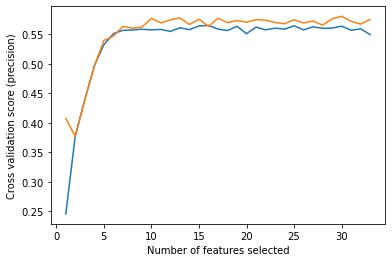

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 3.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected False, Rank: 4.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected False, Rank: 2.000
Column: 24, Selected True, Rank: 1.000
Column: 25, Selected True, Rank:

In [96]:
#Recursive Feature Elimination
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=clf_rf, step=1, cv=StratifiedKFold(2),
              scoring='precision',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train_place, Y_train_place)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (precision)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

In [98]:
#dropping features from dataset not selected by recursive feature elimination
dataopt3 = runs_data.drop(runs_data.columns[[10,21,23]],axis = 1)


With this data set because the number of possible successes goes up, it is not surprising that a smaller number of features is needed to predict this success. We see all the same features eliminated that were eliminated when predicting a winner, but more are added to the list as they are less important in predicting a top 3 placing. Now that we have the optimized dataset for place. We will run the loops again to look for improved performace of both metrics and speed.

In [99]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt3, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.4045344331760486
   Mean AUC:  0.7631313461133714
   Mean Accuracy:  0.6766949952785647
   Mean Time per Split:  1.3572842836380006
 
When Depth = 20
   Mean Precision:  0.4638249739956651
   Mean AUC:  0.7544237938050515
   Mean Accuracy:  0.7402958766131571
   Mean Time per Split:  4.083970785140991
 
When Depth = 100
   Mean Precision:  0.5634452494334161
   Mean AUC:  0.745262453602539
   Mean Accuracy:  0.7728548945546112
   Mean Time per Split:  4.842991328239441
 
When Depth = None
   Mean Precision:  0.5634452494334161
   Mean AUC:  0.745262453602539
   Mean Accuracy:  0.7728548945546112
   Mean Time per Split:  4.824368500709533
 


It is interesting looking at this data where the depth 5 statistics beat the original non-optimized model, however as depth increased. The optimized model didnt seem to keep pace with the original model.  This might be a similar situation to the last attempt at optimization though where the final model did manage to beat out the original model. From this we will use max depth 100 to try to optimize our final model. 

In [100]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 100, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt3, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.5634452494334161
   Mean AUC:  0.745262453602539
   Mean Accuracy:  0.7728548945546112
   Mean Time per Split:  4.9337214708328245
 
When Trees = 75
   Mean Precision:  0.5614956206146656
   Mean AUC:  0.7462119472169518
   Mean Accuracy:  0.7729430280138494
   Mean Time per Split:  6.322962212562561
 
When Trees = 100
   Mean Precision:  0.5656904468786108
   Mean AUC:  0.7479098472805097
   Mean Accuracy:  0.773245199874095
   Mean Time per Split:  7.9841038465499885
 
When Trees = 128
   Mean Precision:  0.5682808927859784
   Mean AUC:  0.7492708546778599
   Mean Accuracy:  0.773736229146994
   Mean Time per Split:  10.447478199005127
 


Interestingly the optimized model here did perform better than the full model. This could be because the algorithm for it is trying to balance bias and variability and last time the metrics just didn't increase the precision, but may have made it more adaptable to another data set. However, just based on metrics alone, the optimized model should be deployed in this case. To compare these to the other types of models we are going to use AUC as it is an easy statistical measure of the predictive power of each model. 

#### Model to predict Won

When Trees = 128
   Mean Precision:  0.5682808927859784
   Mean AUC:  0.7492708546778599
   Mean Accuracy:  0.773736229146994
   Mean Time per Split:  10.447478199005127
 


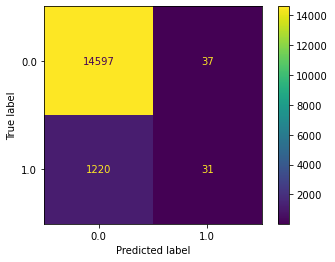

In [101]:
clf_rfw = RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
clf_rfw.fit(X_train,Y_train.values.ravel())
yhat = clf_rfw.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('When Trees =',x)
print('   Mean Precision: ',np.mean(scores['test_precision']))
print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
print(' ')
plot_confusion_matrix(clf_rfw, X_test, Y_test)

#### Model to predict Show

When Trees = 128
   Mean Precision:  0.5682808927859784
   Mean AUC:  0.7492708546778599
   Mean Accuracy:  0.773736229146994
   Mean Time per Split:  10.447478199005127
 


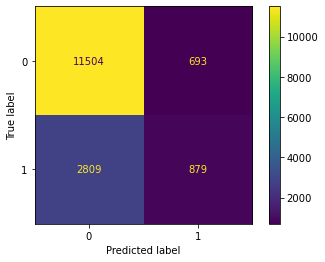

In [104]:
#optimized set of data
X_train_opt,X_test_opt,Y_train_opt,Y_test_opt = train_test_split(dataopt3,runs_target2,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train_place = mmscl_obj.fit_transform(X_train_opt,y = None)
X_test_place = mmscl_obj.transform(X_test_opt)

clf_rfp = RandomForestClassifier(max_depth = 100, n_estimators = 128, random_state = 0, class_weight = 'balanced')
clf_rfp.fit(X_train_opt,Y_train_opt.values.ravel())
yhat = clf_rfp.predict(X_test_opt)
prec = mt.precision_score(Y_test_opt,yhat)
auc = roc_auc_score(Y_test_opt,yhat)
print('When Trees =',x)
print('   Mean Precision: ',np.mean(scores['test_precision']))
print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
print(' ')
plot_confusion_matrix(clf_rfp, X_test_opt, Y_test_opt)

### Sub-Section 5.1.4: Model 4 Logistic Regression

#### Model to predict Won

#### Model to predict Show

## Section 6: Modeling and Evaluation 4

	• Modeling and Evaluation 4
		○ Analyze the results using your chosen method of evaluation. 
            - Use visualizations of the results to bolster the analysis. 
            - Explain any visuals and analyze why they are interesting to someone that might use this model.

### Sub-Section 6.1: Analyze the results using your chosen method of evaluation.

#### Models to Predict Won

When Trees = 13
   Mean Precision:  0.5682808927859784
   Mean AUC:  0.7492708546778599
   Mean Accuracy:  0.773736229146994
   Mean Time per Split:  10.447478199005127
 


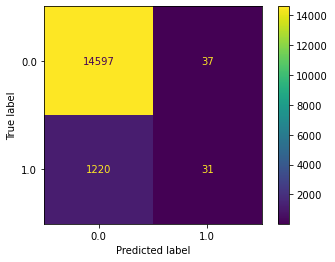

In [122]:
clf_rfw = RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
clf_rfw.fit(X_train,Y_train.values.ravel())
yhatrfw = clf_rfw.predict(X_test)
prec = mt.precision_score(Y_test,yhatrfw)
auc = roc_auc_score(Y_test,yhatrfw)
print('When Trees =',x)
print('   Mean Precision: ',np.mean(scores['test_precision']))
print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
print(' ')
plot_confusion_matrix(clf_rfw, X_test, Y_test)

#### Models to Predict Show

When Trees = 13
   Mean Precision:  0.5682808927859784
   Mean AUC:  0.7492708546778599
   Mean Accuracy:  0.773736229146994
   Mean Time per Split:  10.447478199005127
 


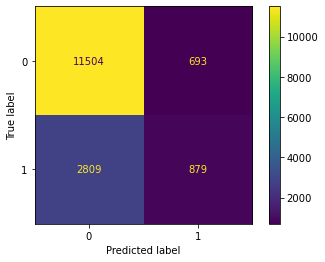

In [123]:
#optimized set of data
X_train_opt,X_test_opt,Y_train_opt,Y_test_opt = train_test_split(dataopt3,runs_target2,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train_place = mmscl_obj.fit_transform(X_train_opt,y = None)
X_test_place = mmscl_obj.transform(X_test_opt)

clf_rfp = RandomForestClassifier(max_depth = 100, n_estimators = 128, random_state = 0, class_weight = 'balanced')
clf_rfp.fit(X_train_opt,Y_train_opt.values.ravel())
yhatrfp = clf_rfp.predict(X_test_opt)
prec = mt.precision_score(Y_test_opt,yhatrfp)
auc = roc_auc_score(Y_test_opt,yhatrfp)
print('When Trees =',x)
print('   Mean Precision: ',np.mean(scores['test_precision']))
print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
print(' ')
plot_confusion_matrix(clf_rfp, X_test_opt, Y_test_opt)

## Section 7: Modeling and Evaluation 5

	• Modeling and Evaluation 5
		○ Discuss the advantages of each model for each classification task, if any. 
			- If there are not advantages, explain why. 
		○ Is any model better than another? 
		○ Is the difference significant with 95% confidence? 
			- Use proper statistical comparison methods. You must use statistical comparison techniques—be sure 
            they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

### Sub-Section 7.1: Discuss the advantages of each model for each classification task, if any.

### Sub-Section 7.2: Is any model better than another? 

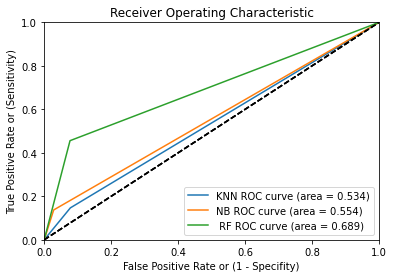

In [139]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


#KNN ROC
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(yhatknnw, Y_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='KNN ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


#NB ROC
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(yhatcnbw, Y_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='NB ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


#RF ROC
fpr, tpr, thresholds = roc_curve(yhatrfw, Y_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=' RF ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

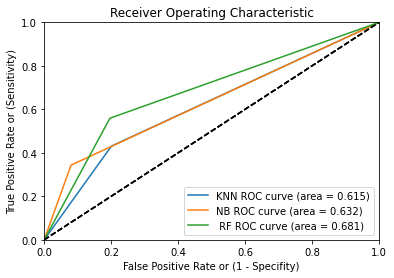

In [141]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


#KNN ROC
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(yhatknnp, Y_test_place)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='KNN ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


#NB ROC
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(yhatcnbp, Y_test_place)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='NB ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


#RF ROC
fpr, tpr, thresholds = roc_curve(yhatrfp, Y_test_place)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=' RF ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Sub-Section 7.3: Is the difference significant with 95% confidence? 

#### Comparing models for Win significance

In [120]:
#Code is referenced from https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/ 

# Input Models
model1= clf_knnw
model2= clf_cnbw

# Statistically compare models
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=runs_data, y=runs_target, scoring='precision', random_seed=1)

# Summarize output
print('Comparison between ',model1, ' and ',model2,':')
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))
if p <= 0.05:
    print('The difference between mean precision of the models is statistically significant')
else:
    print('The difference between mean precision of the models is not statistically signficant')
print(' ')
          
# Input Models
model1= clf_cnbw
model2= clf_rfw

# Statistically compare models
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=runs_data, y=runs_target, scoring='precision', random_seed=1)

# Summarize output
print('Comparison between ',model1, ' and ',model2,':')
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))
if p <= 0.05:
    print('The difference between mean precision of the models is statistically significant')
else:
    print('The difference between mean precision of the models is not statistically signficant')
print(' ')


Comparison between  KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')  and  ComplementNB(alpha=20) :
P-value: 0.004, t-Statistic: 5.007
The difference between mean precision of the models is statistically significant
 
Comparison between  ComplementNB(alpha=20)  and  RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=64,
                       random_state=0) :
P-value: 0.000, t-Statistic: -15.444
The difference between mean precision of the models is statistically significant
 


#### Comparing models for place significance

In [121]:
#Code is referenced from https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/ 

# Input Models
model1= clf_knnp
model2= clf_cnbp

# Statistically compare models
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=runs_data, y=runs_target, scoring='precision', random_seed=1)

# Summarize output
print('Comparison between ',model1, ' and ',model2,':')
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))
if p <= 0.05:
    print('The difference between mean precision of the models is statistically significant')
else:
    print('The difference between mean precision of the models is not statistically signficant')
print(' ')
          
# Input Models
model1= clf_cnbp
model2= clf_rfp

# Statistically compare models
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=runs_data, y=runs_target, scoring='precision', random_seed=1)

# Summarize output
print('Comparison between ',model1, ' and ',model2,':')
print('P-value: %.3f, t-Statistic: %.3f' % (p, t))
if p <= 0.05:
    print('The difference between mean precision of the models is statistically significant')
else:
    print('The difference between mean precision of the models is not statistically signficant')
print(' ')


Comparison between  KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')  and  ComplementNB(alpha=10) :
P-value: 0.004, t-Statistic: 5.023
The difference between mean precision of the models is statistically significant
 
Comparison between  ComplementNB(alpha=10)  and  RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=128,
                       random_state=0) :
P-value: 0.002, t-Statistic: -5.859
The difference between mean precision of the models is statistically significant
 


## Section 8: Modeling and Evaluation 6

	• Modeling and Evaluation 6
		○ Which attributes from your analysis are most important? 
            - Use proper methods discussed in class to evaluate the importance of different attributes. 
		○ Discuss the results and hypothesize about why certain attributes are more important than others for a
        given classification task.

### Sub-Section 8.1: Which attributes from your analysis are most important? 

### Sub-Section 8.1.1: Model 1 KNN

#### Model to predict Won

Precision of classifier with 7 neighbors is: 0.147  AUC: 0.504


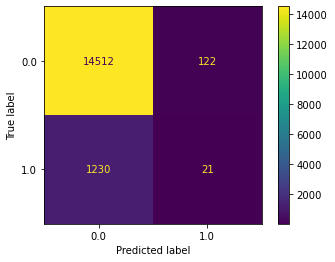

In [107]:
x=7
clf_knnw = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
clf_knnw.fit(X_train,Y_train)
yhat= clf_knnw.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)
plot_confusion_matrix(clf_knnw, X_test, Y_test)

#### Model to predict Show

Precision of classifier with 13 neighbors is: 0.431  AUC: 0.576


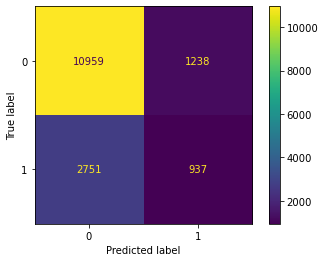

In [108]:
x=13
clf_knnp = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
clf_knnp.fit(X_train_place,Y_train_place)
yhat= clf_knnp.predict(X_test_place)
acc = mt.accuracy_score(Y_test_place,yhat)
prec = mt.precision_score(Y_test_place,yhat)
auc = roc_auc_score(Y_test_place,yhat)
conf = mt.confusion_matrix(Y_test_place,yhat)
print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)
plot_confusion_matrix(clf_knnp, X_test_place, Y_test_place)

### Sub-Section 8.1.2: Model 2 Naive Bayes

#### Model to predict Won

Alpha:20 AUC: 0.6865902112258534 ACC: 0.7488825936418004 Prec: 0.13726023670248946


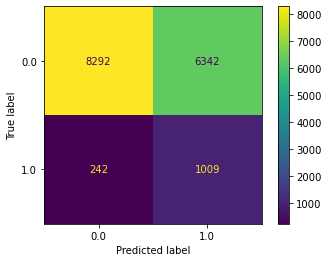

In [109]:
clf_cnbw = ComplementNB(alpha = 20)
clf_cnbw.fit(X_train,Y_train.values.ravel())
yhat = clf_cnbw.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('Alpha:20 AUC:',auc,'ACC:',acc,'Prec:',prec)
plot_confusion_matrix(clf_cnbw,X_test,Y_test)

#### Model to predict Show

Alpha:20 AUC: 0.680016973698415 ACC: 0.7488825936418004 Prec: 0.3431682090364725


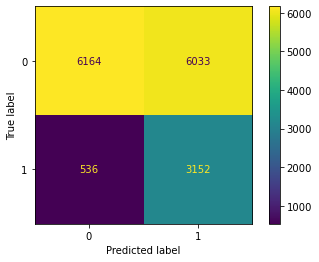

In [110]:
clf_cnbp = ComplementNB(alpha = 10)
clf_cnbp.fit(X_train_place,Y_train_place.values.ravel())
yhat = clf_cnbp.predict(X_test_place)
prec = mt.precision_score(Y_test_place,yhat)
auc = roc_auc_score(Y_test_place,yhat)
print('Alpha:20 AUC:',auc,'ACC:',acc,'Prec:',prec)
plot_confusion_matrix(clf_cnbp,X_test_place,Y_test_place)

### Sub-Section 8.1.3: Model 3 Random Forest

#### Model to predict Won

When Trees = 13
   Mean Precision:  0.5682808927859784
   Mean AUC:  0.7492708546778599
   Mean Accuracy:  0.773736229146994
   Mean Time per Split:  10.447478199005127
 


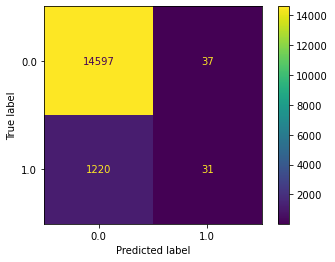

In [111]:
clf_rfw = RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
clf_rfw.fit(X_train,Y_train.values.ravel())
yhat = clf_rfw.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('When Trees =',x)
print('   Mean Precision: ',np.mean(scores['test_precision']))
print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
print(' ')
plot_confusion_matrix(clf_rfw, X_test, Y_test)

#### Model to predict Show

When Trees = 13
   Mean Precision:  0.5682808927859784
   Mean AUC:  0.7492708546778599
   Mean Accuracy:  0.773736229146994
   Mean Time per Split:  10.447478199005127
 


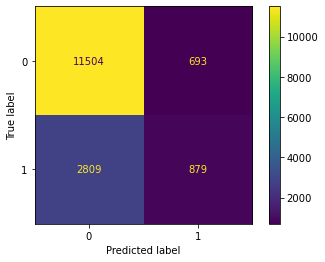

In [112]:
#optimized set of data
X_train_opt,X_test_opt,Y_train_opt,Y_test_opt = train_test_split(dataopt3,runs_target2,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train_place = mmscl_obj.fit_transform(X_train_opt,y = None)
X_test_place = mmscl_obj.transform(X_test_opt)

clf_rfp = RandomForestClassifier(max_depth = 100, n_estimators = 128, random_state = 0, class_weight = 'balanced')
clf_rfp.fit(X_train_opt,Y_train_opt.values.ravel())
yhat = clf_rfp.predict(X_test_opt)
prec = mt.precision_score(Y_test_opt,yhat)
auc = roc_auc_score(Y_test_opt,yhat)
print('When Trees =',x)
print('   Mean Precision: ',np.mean(scores['test_precision']))
print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
print(' ')
plot_confusion_matrix(clf_rfp, X_test_opt, Y_test_opt)

### Sub-Section 8.1.4: Model 4 Logistic Regression

#### Model to predict Won

#### Model to predict Show

## Section 9: Deployment

	• Deployment
		○ How useful is your model for interested parties (i.e., the companies or organizations that might want
        to use it for prediction)? 
		○ How would you measure the model's value if it was used by these parties? 
		○ How would your deploy your model for interested parties? 
		○ What other data should be collected? 
		○ How often would the model need to be updated, etc.? 

### Sub-Section 9.1: How useful is your model for interested parties

### Sub-Section 9.2: How would you measure the model's value if it was used by these parties? 

### Sub-Section 9.3: How would your deploy your model for interested parties? 

### Sub-Section 9.4: What other data should be collected?

### Sub-Section 9.5: How often would the model need to be updated? 

## Section 10: Exceptional Work

	• Exceptional Work
		○ You have free reign to provide additional analyses. 
			- One idea: grid search parameters in a parallelized fashion and visualize the performances across
            attributes. 
			- Which parameters are most significant for making a good model for each classification algorithm?

### Sub-Section 10.1: Recursive Feature Selection

We used RFE during our section on Random Forests. Idealy we would have liked to deploy it to our KNN models as they took the longest to run, but since KNN fits and predicts at the same time, there was no way to apply it to those models. RFE seemed to have mixed effects on the Random Forest models. In attempting to predict wins, it beat the full model that used all features. However, it did not have this success again when running to predict placing. It's metrics were consistently under that of the full model. 

### Sub-Section 10.2: Grid Search

### Sub-Section 10.3: Extra Model to predict Won and Show

# Line break between reports
=========================================

## Example on how to scale, model, and get metrics while using cross validation with a pipeline
## Example also shows how to use this to tune a tune a hyper-parameter

#### Possible adjustments you should look at
- The parameter being hypertuned and values at the start of the loop
- Is the scaler type what you want
- Is the model information updated
- The cross_validate() function uses runs_data and runs_target to check for win. You need to unpdate to runs_target2 to check for show
- You should also update the first print statement to reflect your hyperparameter name
- This should be applied to all models so we are consistent because original method was not fully utilizing all splits

In [ ]:
#Referenced website: https://machinelearningmastery.com/data-preparation-without-data-leakage/
Kvals = [5,10]
for k in Kvals:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    #steps.append(('model', KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')))
    steps.append(('model', KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    #cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)
    cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 0)

    
    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When k =',k)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')